In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython import display 
import itertools
from IPython.display import display
import random, operator
from random import choices, randint, randrange, random, sample, seed 
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial

In [2]:
#np.random.seed(2021)

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class MarketConfig: 
    #class attributes
    t0 = 2016 #The starting year for evaluation of the pay-offs
    T = 35  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2016, 2051)
    distance = np.array([11810]) #nautical miles #Notteboom (2006)  
    port_time =  np.array([264])  #hours ==> 11 days in a year  #Notteboom (2006)
    demand_16_20 = np.array([1303780  for j in range(5)]) #in TEU #placehplder to be calibrated with the chosen route 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([1800])  ## in US$/TEU 
    SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter, demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        self.market_capacity = 0 
         
    
    def get_market_capacity (self, firm_instance):
        self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('./data/real_growth_rate.csv') #import IMF data
        #-------> 2.Construct GDP projection path 2016-2050 based on projection growth data 
        gdp_growth= G_df.values[:,1:] 
        g =1 +(gdp_growth/100)  
        self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        for foo in range (1,MarketConfig.T):
            self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([1.00 for j in range(MarketConfig.T)])
        for moo in range (1,MarketConfig.T):
            sub_g = g[:,0:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        self.market_demand = np.multiply(loo, MarketConfig.demand_16_20[0])
        #print(Y) # size = 1 dimesion array with size T=35 years
        self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_16_20[0] )
        return self.market_demand, self.gdp, self.market_psy
    
    
    def get_damage(self):
        pass
    
    def get_global_abatement_benefits(self):
        pass 
    
    def get_firm_abatement_benefits():
        pass

In [5]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, max_number_of_vessel, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        #self.bau_emission = bau_emission
         
   
    # Firm methods 
    def get_market_share(self , market_instance):
        '''return market share of the firm accoding to it s capacity'''
        self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        return self.market_share
        
    def get_firm_param(self, market_instance):
        self.psy = np.multiply (self.market_share , market_instance.market_psy)
        return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance, period_index):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed)
        self.voyage_time = self.time_at_sea + market_instance.port_time   
        self.number_of_trips_to_meet_demand = np.true_divide(self.firm_demand[period_index -1 ], self.capacity)
        self.max_trips_per_vessel = np.true_divide(market_instance.annual_working_time, self.voyage_time)
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel)
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand)
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(market_instance.SFOC_main,market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        #self.main_fuel_parameter = market_instance.SFOC_main * market_instance.eng_load_main * self.main_engine_power * 10**(-6)
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )      
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        self.main_fuel_con= np.multiply(np.multiply(np.multiply(market_instance.distance, self.ship_energy), np.power(self.operational_speed, 2)) , self.number_of_trips_to_meet_demand)
        self.main_fuel_cons = market_instance.distance * self.ship_energy * (self.operational_speed**2) *self.number_of_trips_to_meet_demand
        return self.main_fuel_cons
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( market_instance.SFOC_aux, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6))
        #self.aux_fuel_parameter = market_instance.SFOC_aux * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        return self.aux_fuel_cons 
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        return self.fuel_cost
        
    def get_total_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        return self.total_cost 
    
    def get_revenue(self,market_instance, period_index):
        self.revenue = np.multiply(self.firm_demand[period_index - 1], market_instance.freight_rate)
        return self.revenue
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        return self.period_profit
    
    def get_discounted_period_profit(self,market_instance, period_index):
        self.discounted_period_profit = np.multiply( np.power( 1+ market_instance.discount_rate, - period_index), self.period_profit) 
        return self.discounted_period_profit
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self_carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  

        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self_carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  

        self_carbon_emissions = self_carbon_main_emissions + self_carbon_aux_emissions 
        return self_carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self_sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  

        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self_sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  

        self_sulfur_emissions = self_sulfur_main_emissions + self_sulfur_aux_emissions 
        return self_sulfur_emissions

In [6]:
#====> Iinitialisation of chromo and population objects 
Chromo = List[float] 
Population = List[Chromo]  

#====> Iinitialisation of function objects
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Chromo], Tuple[float, int, float, float]] #int to refelct max # of vessel
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one

#======>
def generate_chromo(lower_bound:float, upper_bound:float) -> Chromo:
    return np.random.uniform(lower_bound, upper_bound)

#======>
def generate_population(size: int, chromo_lower_bound: float, chromo_upper_bound: float) -> Population: 
    return np.array([generate_chromo(chromo_lower_bound, chromo_upper_bound) for _ in range(size)])

#=====>
def fitness (chromo: Chromo, firm: Firm, sim_game: MarketConfig, max_number_of_vessel: int, period_index: int) -> Tuple[float, int, float, float]:
    
    operational_speed = firm.update_vessel_speed(chromo)
    #print("operational_speed", operational_speed)
    
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game, period_index)
    #print("min number of vessel is", min_number_vessels_sim )
    #print("number of trips to meet demand", trips_to_meet_demand_sim )
    #print("Time spent at sea", time_at_sea_sim )

    number_vessels_sim  = firm.get_number_of_vessel()
    #print("number of vessel is", number_vessels_sim)
    
    #Insert Model Constraints Here, Update Vessel speed constraint 
    if number_vessels_sim > max_number_of_vessel:
        return np.zeros(4)
    else:
        main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)
        #print('main fuel consumption is ', main_fuel_con_sim)
        
        aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
        #print('aux fuel consumption is ', aux_fuel_con_sim)

        fuel_cost_sim = firm.get_fuel_cost(sim_game)
        #print( "fuel cost",fuel_cost_sim)
        
        total_cost_sim = firm.get_total_cost()
        #print("total cost",total_cost_sim)
        
        revenues_sim = firm.get_revenue(sim_game, period_index)
        #print("revenues", revenues_sim)
        
        period_profits_sim = firm.get_period_profits()
        #print ("period profits ", period_profits_sim)
        
        discounted_period_profits_sim = firm.get_discounted_period_profit(sim_game, period_index)
        #print("discounted period profits ", discounted_period_profits_sim)
        
        #We will see about the carbon and sulfir emississons 
        carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game)
        #print("carbon emissions",carbon_emissions_sim)
        
        sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
        #print( "sulfur emissions", sulfur_emissions_sim)
        return  discounted_period_profits_sim, number_vessels_sim, carbon_emissions_sim, sulfur_emissions_sim

#=====>
def selection_pair(population: Population, fitness_func: FitnessFunc) -> Population:
    '''Roulette Wheel Selection: select a pair of chromo which will be the parent of 2 new chromo for the next generation, Solution with higher fitness should be more likely to be chosen for reproduction'''
    return choices(population = population,weights=[fitness_func(chromo)[0] for chromo in population],k=2) 



#=====>
def blend_crossover (a: Chromo, b: Chromo) -> Tuple[Chromo, Chromo]:
    lower = min(a,b) -  0.5 * (max(a,b) - min (a,b))
    upper = max(a,b) +  0.5 * (max(a,b) - min (a,b))                    
    return np.random.uniform (lower, upper, 2) 


#=====>
def mutation(chromo: Chromo, chromo_lower_bound: float, chromo_upper_bound: float, num: int = 1, 
             probability: float = 0.5, variance: float = 1) -> Chromo: 
    for _ in range(num):
        # if random retuns a value lower or equal to probablity, the chromo falls whitihinn the mutation probabality 
        if random() <= probability:
            chromo += np.random.normal(0, variance, 1)
    
        if chromo <chromo_lower_bound:
            chromo = chromo_lower_bound
            
        elif chromo > chromo_upper_bound: 
            chromo = chromo_upper_bound
        return chromo

#=====>
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = False
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = True
    return result

#=====>
def run_evolution(populate_func: PopulateFunc, fitness_func: FitnessFunc, mutation_func: MutationFunc, 
                  generation_limit: int = 100, number_of_similarity: int = 50, selection_func: SelectionFunc = selection_pair,
                  crossover_func: CrossoverFunc = blend_crossover ) -> Tuple[Population, pd.DataFrame ]:
    """The evolutionnary main loop""" 
    #1. Genrate the 1st generation: Initial generation/population
    population = populate_func()
    
    #2 Simulate until you reach generation limit,
    i = 0
    progress = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Discounted profit', 
                                'Number of vessels', 'Carbon Emissions', 'Sulfur Emissions'])
    
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions 
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        
        progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
        
        #Similarity check
        if fitness_similarity_chech(progress['Firm Discounted profit'], number_of_similarity) == True:
            break
#         print(progress)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
              
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2]         
        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection 
            parents = selection_func(population, fitness_func)
            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    progress = progress.append({'Generation': i+1,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
    #print(progress)
    return population, progress

# 1. Set Up Simulation Parameters:

## * Firm 1:

In [7]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([5905]) 
max_number_of_vessel_1= np.array([50]) 
design_speed_1 = np.array([23.3]) #design speed of the vessel in knots
min_speed_1 = np.array([10])
max_speed_1 = np.array([30])
main_engine_power_1 =np.array([41186])  # main engine power in kW
aux_engine_power_1 =np.array([2433])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([6750000])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "HFO"

## * Firm 2:

In [8]:
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([6470])
max_number_of_vessel_2 = np.array([50])
design_speed_2 = np.array([24.7])  #design speed of the vessel in knots
min_speed_2 = np.array([10])
max_speed_2 = np.array([30])
main_engine_power_2 = np.array([56273]) # main engine power in kW
aux_engine_power_2 =np.array([2433])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([ 6750000]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "HFO"

## * Market :

In [9]:
                    #===========================> Market Attributes <==========================#
firms = 2
pollution_decay_parameter =  np.array([0.2])
pollution_damage_parameter =  np.array([1.5])

year = np.arange(2016, 2051)
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([1800]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# 2. Initialize Game and Set up firm and market objects 

In [10]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, max_number_of_vessel_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1) 

firm_2 = Firm(index_2, capacity_2, max_number_of_vessel_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2) 

game_config = MarketConfig(firms, pollution_decay_parameter, pollution_damage_parameter, income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
for  firm_object in Firm._registry:
    market_capacity_sim = game_config.get_market_capacity(firm_object)

# 3. Market Demand

In [11]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
print("market demand", market_demand_sim)

# Get each firm's  market share  
firm_1_market_share_sim = firm_1.get_market_share(game_config)
print("firm 1 market share", firm_1_market_share_sim)

firm_2_market_share_sim = firm_2.get_market_share(game_config)
print("firm 2 market share", firm_2_market_share_sim)

market demand [1303780.         1378613.27053661 1417081.19385409 1448735.913652
 1397511.98183639 1455352.28446974 1504050.11466377 1549602.07735933
 1594072.22320876 1638552.17226732 1684273.26074193 1731270.12057536
 1779578.35005746 1829234.54078948 1880276.30540081 1932742.30603904
 1986672.28365504 2042107.08810522 2099088.70909364 2157660.30797763
 2217866.2504608  2279752.14019835 2343364.85334008 2408752.57403719
 2475964.83093995 2545052.53471369 2616068.01660168 2689065.06806397
 2764098.98152235 2841226.59224218 2920506.32138292 3001998.22024985
 3085764.01578064 3171867.15730103 3260372.86458528]
firm 1 market share [0.47717172]
firm 2 market share [0.52282828]


### Graphing Market Demand:

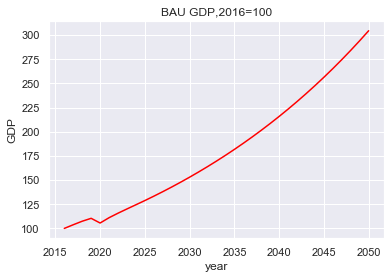

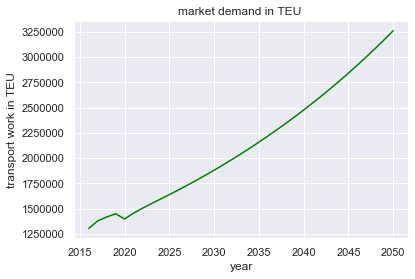

In [13]:
#======> Plotting BAU GDP,2016=100
sns.set()
ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
ax.set(xlabel='year', ylabel='GDP')
plt.title("BAU GDP,2016=100" )
plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("market demand in TEU " )
plt.show()

#======> Plotting Marketshare per firm



# 4. Compute BAU Pollution Stock

## a. Firm 1:

In [14]:
 # 7.Get firm passthrough parameter
firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
print("firm 1 ship energy", firm_1_ship_energy_sim)

firm 1 demand [ 622126.94141414  657835.26161767  676191.06664311  691295.80364566
  666853.19214092  694452.94867021  717690.17592643  739426.28418641
  760646.18004426  781870.75371625  803687.56401464  826113.13632303
  849164.45713853  872858.98693833  897214.6734054   922249.96502307
  947983.82504913  974435.7458797  1001625.76381397 1029574.47423094
 1058303.04718958 1087833.24346435 1118187.43102814 1149388.60199512
 1181460.39003639 1214427.08828156 1248313.66771983 1283145.79611457
 1318949.85744561 1355752.97189415 1393583.01638514 1432468.64570306
 1472439.31419674 1513525.29808991 1555757.71841423]
firm 1 ship energy [0.00053659]


In [61]:
firm_2_demand_sim[31]

1569529.5745467916

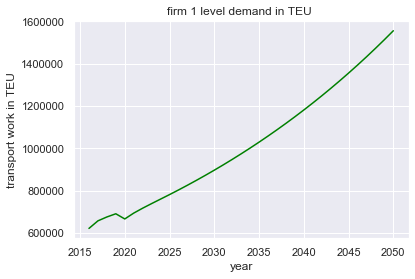

In [15]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 1 level demand in TEU " )
plt.show()

## b. Firm 2

In [16]:
# 7.Get firm passthrough parameter
firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
print("firm 2 ship energy", firm_2_ship_energy_sim)

firm 2 demand [ 681653.05858586  720778.00891894  740890.12721099  757440.11000634
  730658.78969547  760899.33579953  786359.93873734  810175.79317292
  833426.0431645   856681.41855108  880585.6967273   905156.98425233
  930413.89291893  956375.55385115  983061.63199541 1010492.34101596
 1038688.45860591 1067671.34222552 1097462.94527966 1128085.83374669
 1159563.20327122 1191918.89673401 1225177.42231195 1259363.97204207
 1294504.44090355 1330625.44643213 1367754.34888185 1405919.27194941
 1445149.12407673 1485473.62034803 1526923.30499777 1569529.57454679
 1613324.7015839  1658341.85921112 1704615.14617105]
firm 2 ship energy [0.00061541]


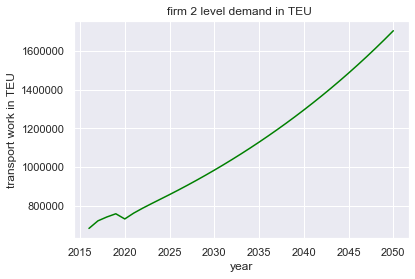

In [17]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_2_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm 2 level demand in TEU " )
plt.show()

## c. Compute BAU emissions throughout the planning horizon

In [18]:
def BAU_emissions_period(p_index):
    """results_period: dict index by firm1, .., firmn contains ganeration vessel speed,
        p_index>= 1,.."""
    results_period = {}
    optimum_solution_period ={}
    carbon_industry_emission_period = 0
    sulfur_industry_emission_period = 0
    for firm_object in (Firm._registry):
        population, results  = run_evolution( populate_func = partial(generate_population,
                                                                      size=50,
                                                                      chromo_lower_bound = firm_object.min_speed ,
                                                                      chromo_upper_bound = firm_object.max_speed),
                                             fitness_func = partial(fitness,
                                                                    firm = firm_object,
                                                                    sim_game = game_config,
                                                                    max_number_of_vessel = firm_object.max_number_of_vessel,
                                                                    period_index = p_index),
                                             generation_limit = 100,
                                             number_of_similarity = 40,
                                             mutation_func = partial (mutation,
                                                                      probability = 0.5, 
                                                                      variance = 1,
                                                                      chromo_lower_bound =  firm_object.min_speed,
                                                                      chromo_upper_bound= firm_object.max_speed  
                                                                     )
                                            )
        results_period["firm" + str(firm_object.index)] = results
        
        # Store Optimum Solution table     
        optimum_solution_period["firm" + str(firm_object.index)] = results_period["firm" + str(firm_object.index)].iloc[[-1]]

        # Compute industry level BAU emissions
        carbon_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Carbon Emissions"].values
        sulfur_industry_emission_period += optimum_solution_period["firm" + str(firm_object.index)]["Sulfur Emissions"].values
        #print("carbon_industry_emission_period")
    #print(carbon_industry_emission_period)
    return results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period

In [19]:
#Test Single period :
# BAU_emissions_period(0)

In [20]:
BAU_carbon_pollution_stock = np.zeros(MarketConfig.T)
BAU_sulfur_pollution_stock = np.zeros(MarketConfig.T)
results = {} #empty dict
optimum_solution={} #empty dict 
#MarketConfig.T
for my_period_index in range(MarketConfig.T):
    #Get results for period "period"
    #BAU_emissions_period(my_period_index +1) Needs to start from 1 till T 
    #Results also start from 1 till T 
    results_period, optimum_solution_period, carbon_industry_emission_period, sulfur_industry_emission_period = BAU_emissions_period(my_period_index +1)
    results[my_period_index+1]  = results_period
    optimum_solution [my_period_index +1 ] = optimum_solution_period # a dict 
    
    if my_period_index == 0 :
        BAU_carbon_pollution_stock[0]  =  carbon_industry_emission_period 
        BAU_sulfur_pollution_stock[0]  =  carbon_industry_emission_period
    else: 
        BAU_carbon_pollution_stock[my_period_index] = (1- pollution_decay_parameter ) * BAU_carbon_pollution_stock[my_period_index -1 ] + carbon_industry_emission_period
        BAU_sulfur_pollution_stock[my_period_index] = (1- pollution_decay_parameter ) * BAU_sulfur_pollution_stock[my_period_index -1 ] + sulfur_industry_emission_period


In [21]:
results

{1: {'firm1':    Generation         Vessel Speed Firm Discounted profit Number of vessels  \
  0           0  [14.10686891133995]    [909839859.4710358]            [18.0]   
  1           1  [14.10686891133995]    [909839859.4710358]            [18.0]   
  2           2  [14.10686891133995]    [909839859.4710358]            [18.0]   
  3           3              14.0474     [910243976.907843]            [18.0]   
  4           4              14.0474     [910243976.907843]            [18.0]   
  ..        ...                  ...                    ...               ...   
  56         56              14.0089    [910504534.9207523]            [18.0]   
  57         57              14.0089    [910504534.9207523]            [18.0]   
  58         58              14.0089    [910504534.9207523]            [18.0]   
  59         59              14.0089    [910504534.9207523]            [18.0]   
  60         60              14.0089    [910504534.9207523]            [18.0]   
  
          Car

In [71]:
optimum_solution[1]['firm2']["Sulfur Emissions"].values+optimum_solution[1]['firm1']["Sulfur Emissions"].values

array([array([18407.82688539])], dtype=object)

In [72]:
optimum_solution[1]['firm2']["Carbon Emissions"].values+optimum_solution[1]['firm1']["Carbon Emissions"].values

array([array([973177.33438361])], dtype=object)

In [26]:
BAU_carbon_pollution_stock

array([  973177.33438361,  1813916.77582299,  2521269.75742042,
        3104127.11129822,  3562093.69449066,  3951747.23330389,
        4267652.94806426,  4570517.17915344,  4858542.1089706 ,
        5084267.58262591,  5367033.5702568 ,  5592500.4346422 ,
        5777319.16809068,  6035776.81728215,  6250642.26937899,
        6435455.67671387,  6599251.26944403,  6854038.74745384,
        7079808.33245087,  7286153.01829309,  7480690.81564326,
        7670278.0755122 ,  7859349.11572189,  8052238.70953025,
        8303857.74106628,  8503015.66907215,  8767501.3809389 ,
        9037413.34923347,  9316187.97615541,  9555225.86493729,
        9817771.48436422, 10105350.63522205, 10417097.62632836,
       10703097.471147  , 10922700.51288723])

In [27]:
BAU_sulfur_pollution_stock

array([973177.33438361, 798163.8777804 , 658843.66867932, 547672.20500455,
       458751.67832287, 387940.43390003, 331180.20919563, 286813.45630351,
       252262.38361031, 224307.33054591, 204277.09464534, 188030.19898748,
       174928.47652479, 166971.6670616 , 160585.48236568, 155566.10115883,
       151706.53721887, 151445.23153013, 151531.96085474, 151982.70542571,
       152809.13581784, 154039.75380932, 155671.36600724, 157721.04970116,
       161479.8592888 , 164128.48982731, 168545.94443943, 173205.96973203,
       178163.12092689, 182186.87404617, 186827.00091183, 192104.6705703 ,
       197984.49766582, 203218.08077643, 206779.6856581 ])

# Firms'net present value

# Plotting and Analysis

### Evaluatin GA performance

### Firm 1, Period 1

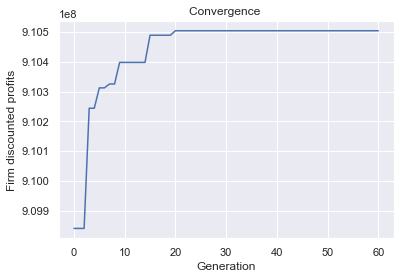

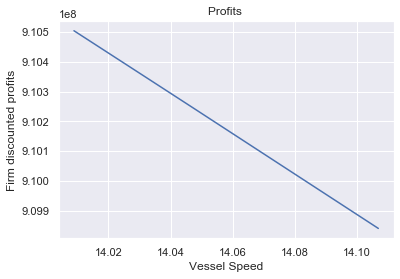

In [28]:
plt.plot(results[1]["firm1"]['Generation'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Convergence " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Generation')
plt.show()
#############
plt.plot(results[1]["firm1"]['Vessel Speed'].values, results[1]["firm1"]['Firm Discounted profit'].values)
plt.title("Profits " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Vessel Speed')
plt.show()

In [29]:
(results[1]["firm1"])

,Generation,Vessel Speed,Firm Discounted profit,Number of vessels,Carbon Emissions,Sulfur Emissions
0,0,[14.10686891133995],[909839859.4710358],[18.0],[489763.62677262316],[9347.948470935089]
1,1,[14.10686891133995],[909839859.4710358],[18.0],[489763.62677262316],[9347.948470935089]
2,2,[14.10686891133995],[909839859.4710358],[18.0],[489763.62677262316],[9347.948470935089]
3,3,14.0474,[910243976.907843],[18.0],[486605.7146709569],[9269.930193482021]
4,4,14.0474,[910243976.907843],[18.0],[486605.7146709569],[9269.930193482021]
...,...,...,...,...,...,...
56,56,14.0089,[910504534.9207523],[18.0],[484568.6936990772],[9219.551684946524]
57,57,14.0089,[910504534.9207523],[18.0],[484568.6936990772],[9219.551684946524]
58,58,14.0089,[910504534.9207523],[18.0],[484568.6936990772],[9219.551684946524]
59,59,14.0089,[910504534.9207523],[18.0],[484568.6936990772],[9219.551684946524]


## Export Results to spreadsheet

In [30]:
writer = pd.ExcelWriter('results.xlsx', engine='xlsxwriter')   
for periode in results.keys():
    for firm in results[periode].keys():
        sheet_name = "period" + str(periode) + firm
        results[periode][firm].to_excel(writer, sheet_name = sheet_name, index =False)
writer.save()

In [31]:
writer_1 = pd.ExcelWriter('optimum_solution.xlsx', engine='xlsxwriter')   
for periode in optimum_solution.keys():
    for firm in optimum_solution[periode].keys():
        sheet_name = "period" + str(periode) + firm
        optimum_solution[periode][firm].to_excel(writer_1, sheet_name = sheet_name, index =False)
writer_1.save()

# Resuts:

In [32]:
column_names = optimum_solution[1].keys()
row_names = optimum_solution.keys()

## a. BAU emission path

### Carbon

In [33]:
carbon_emission = pd.DataFrame(columns = column_names,   index = row_names )

for periode in optimum_solution.keys():
    for firm in optimum_solution[periode].keys():
        carbon_emission[firm][periode] = ((optimum_solution[periode][firm]["Carbon Emissions"]).values).astype(float)

carbon_emission

,firm1,firm2
1,[484568.6936990772],[488608.6406845288]
2,[514132.9233238311],[521241.9849922741]
3,[504387.7557059834],[565748.5810560398]
4,[538456.0883044495],[548655.21705744]
5,[535912.2256603625],[542879.7797917232]
6,[546083.9506674735],[555988.3270438878]
7,[546561.0280491952],[559694.1333719529]
8,[545088.8011377429],[611306.0195642832]
9,[593028.3602429369],[609100.0054049107]
10,[589310.6292962341],[608123.2661532002]


### Sulfur


In [34]:
sulfur_emission = pd.DataFrame(columns =column_names ,  index = row_names )

for periode in optimum_solution.keys():
    for firm in optimum_solution[periode].keys():
        sulfur_emission[firm][periode] = ((optimum_solution[periode][firm]["Sulfur Emissions"]).values).astype(float)

sulfur_emission

,firm1,firm2
1,[9219.551684946524],[9188.275200444104]
2,[9792.044873089964],[9829.965400424964]
3,[9466.7823639087],[10845.784091089145]
4,[10244.900739915678],[10352.369321185099]
5,[10289.535266049354],[10324.379053178103]
6,[10419.452278485549],[10519.63896324351]
7,[10327.231717933772],[10500.63035767236]
8,[10190.385090324786],[11678.903856679406]
9,[11286.385461868595],[11525.233105635725]
10,[11098.289076684474],[11399.134580980843]


## b.Pollution Stock

### Carbon

In [35]:
BAU_carbon_pollution_stock

array([  973177.33438361,  1813916.77582299,  2521269.75742042,
        3104127.11129822,  3562093.69449066,  3951747.23330389,
        4267652.94806426,  4570517.17915344,  4858542.1089706 ,
        5084267.58262591,  5367033.5702568 ,  5592500.4346422 ,
        5777319.16809068,  6035776.81728215,  6250642.26937899,
        6435455.67671387,  6599251.26944403,  6854038.74745384,
        7079808.33245087,  7286153.01829309,  7480690.81564326,
        7670278.0755122 ,  7859349.11572189,  8052238.70953025,
        8303857.74106628,  8503015.66907215,  8767501.3809389 ,
        9037413.34923347,  9316187.97615541,  9555225.86493729,
        9817771.48436422, 10105350.63522205, 10417097.62632836,
       10703097.471147  , 10922700.51288723])

### Sulfur


In [36]:
BAU_sulfur_pollution_stock

array([973177.33438361, 798163.8777804 , 658843.66867932, 547672.20500455,
       458751.67832287, 387940.43390003, 331180.20919563, 286813.45630351,
       252262.38361031, 224307.33054591, 204277.09464534, 188030.19898748,
       174928.47652479, 166971.6670616 , 160585.48236568, 155566.10115883,
       151706.53721887, 151445.23153013, 151531.96085474, 151982.70542571,
       152809.13581784, 154039.75380932, 155671.36600724, 157721.04970116,
       161479.8592888 , 164128.48982731, 168545.94443943, 173205.96973203,
       178163.12092689, 182186.87404617, 186827.00091183, 192104.6705703 ,
       197984.49766582, 203218.08077643, 206779.6856581 ])

## Damages from pollution to the industry:

## Carbon

In [40]:
BAU_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_carbon_pollution_stock,2)
BAU_industry_carbon_damages

array([7.10305593e+11, 2.46772055e+12, 4.76760089e+12, 7.22670384e+12,
       9.51638362e+12, 1.17122296e+13, 1.36596463e+13, 1.56672205e+13,
       1.77040736e+13, 1.93873326e+13, 2.16037870e+13, 2.34570458e+13,
       2.50330626e+13, 2.73229513e+13, 2.93028966e+13, 3.10613173e+13,
       3.26625880e+13, 3.52333854e+13, 3.75927645e+13, 3.98160194e+13,
       4.19705513e+13, 4.41248743e+13, 4.63270264e+13, 4.86289112e+13,
       5.17155400e+13, 5.42259566e+13, 5.76518103e+13, 6.12561300e+13,
       6.50935188e+13, 6.84767560e+13, 7.22914777e+13, 7.65885836e+13,
       8.13869422e+13, 8.59172216e+13, 8.94790399e+13])

## Sulfur

In [41]:
sulfur_industry_carbon_damages = 0.5* pollution_damage_parameter * np.power(BAU_sulfur_pollution_stock,2)
sulfur_industry_carbon_damages

array([7.10305593e+11, 4.77799182e+11, 3.25556235e+11, 2.24958633e+11,
       1.57839827e+11, 1.12873335e+11, 8.22602482e+10, 6.16964690e+10,
       4.77272326e+10, 3.77353339e+10, 3.12968485e+10, 2.65165168e+10,
       2.29499789e+10, 2.09096532e+10, 1.93407729e+10, 1.81506089e+10,
       1.72611551e+10, 1.72017436e+10, 1.72214514e+10, 1.73240571e+10,
       1.75129740e+10, 1.77961843e+10, 1.81751806e+10, 1.86569471e+10,
       1.95568087e+10, 2.02036209e+10, 2.13058015e+10, 2.25002310e+10,
       2.38065732e+10, 2.48940428e+10, 2.61782462e+10, 2.76781533e+10,
       2.93983960e+10, 3.09731913e+10, 3.20683788e+10])